# https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-search-trends.md

# https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-epidemiology.md


## RQ: What search keywords can be helpful in determining future spikes


<img src="../sketches/case_search_correlation.png" alt="Drawing" style="width: 600px;"/>


In [1]:
import pandas as pd
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [2]:
relevant_locations = \
    ["US", "US_AL", "US_AK", "US_AS", "US_AZ", "US_AR", "US_CA", \
     "US_CO", "US_CT", "US_DE", "US_DC", "US_FL", "US_GA", "US_GU", \
     "US_HI", "US_ID", "US_IL", "US_IN", "US_IA", "US_KS", "US_KY", \
     "US_LA", "US_ME", "US_MD", "US_MA", "US_MI", "US_MN", "US_MS", \
     "US_MO", "US_MT", "US_NE", "US_NV", "US_NH", "US_NJ", "US_NM", \
     "US_NY", "US_NC", "US_ND", "US_MP", "US_OH", "US_OK", "US_OR", \
     "US_PA", "US_PR", "US_RI", "US_SC", "US_SD", "US_TN", "US_TX", \
     "US_UT", "US_VT", "US_VA", "US_VI", "US_WA", "US_WV", "US_WI", "US_WY"]

In [12]:
relevant_search_headers = ["date","location_key"]

"""
    We investigate searches that are relevant to covid symptoms
        - Fever or chills
        - Cough
        - Shortness of breath or difficulty breathing
        - Fatigue
        - Muscle or body aches
        - Headache
        - New loss of taste or smell
        - Sore throat
        - Congestion or runny nose
        - Nausea or vomiting
        - Diarrhea
"""

relevant_search_headers += \
    ["search_trends_fever", "search_trends_chills", "search_trends_cough", \
     "search_trends_shallow_breathing", "search_trends_shortness_of_breath", \
     "search_trends_fatigue", "search_trends_headache", \
     "search_trends_cluster_headache", "search_trends_sore_throat", \
     "search_trends_nasal_congestion", "search_trends_nausea", \
     "search_trends_vomiting", "search_trends_diarrhea", \
     "search_trends_chest_pain", "search_trends_burning_chest_pain", "search_trends_back_pain"] 

### Search trends

In [6]:
search_trend_df = pd.read_csv("../raw_data/google-search-trends.csv")
search_trend_df = search_trend_df[relevant_search_headers]
search_trend_df = search_trend_df[search_trend_df['location_key'].isin(relevant_locations)]
search_trend_df['date'] = pd.to_datetime(search_trend_df['date'])
search_trend_df = search_trend_df.sort_values(by = 'date')

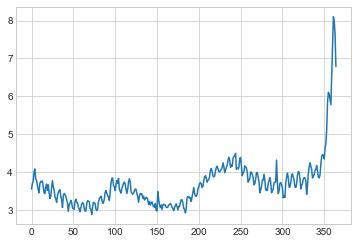

In [7]:
usa_fever_trend = search_trend_df[search_trend_df['location_key'] == "US"][["date", "search_trends_fever"]]
usa_fever_trend = usa_fever_trend.set_index(['date'])
usa_fever_trend = usa_fever_trend.loc[datetime.date(2021,1,1):datetime.date(2021,12,31)]
plt.plot(range(len(usa_fever_trend)), usa_fever_trend["search_trends_fever"].values)

### Cases

In [9]:
cases_df = pd.read_csv("../raw_data/epidemiology.csv")
cases_df = cases_df[cases_df['location_key'].isin(relevant_locations)]
cases_df['date'] = pd.to_datetime(cases_df['date'])
cases_df = cases_df.sort_values(by = 'date')

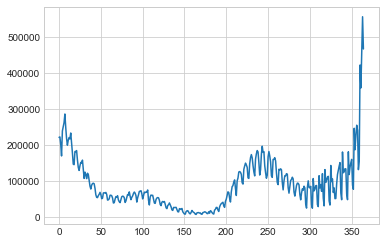

In [10]:
usa_cases = cases_df[cases_df['location_key'] == "US"][["date", "new_confirmed"]]
usa_cases = usa_cases.set_index(['date'])
usa_cases = usa_cases.loc[datetime.date(2021,1,1):datetime.date(2021,12,31)]

plt.plot(range(len(usa_cases)), usa_cases["new_confirmed"].values)

### Check correlation with lag

In [13]:
corref = np.corrcoef(
    x = usa_fever_trend["search_trends_fever"].values,
    y = usa_cases["new_confirmed"].values
)

print ("Lag:", 0, "Correlation:", corref[0, 1])
    
for shift in range(1, 20):
    corref = np.corrcoef(
        x = usa_fever_trend["search_trends_fever"].values[:-shift],
        y = usa_cases["new_confirmed"].values[shift:]
    )
    
    print ("Lag:", shift, "Correlation:", corref[0, 1])

    
"""
Lag: 0 Correlation: 0.7664096532635916
Lag: 1 Correlation: 0.802299463761596
Lag: 2 Correlation: 0.7968023460529252
Lag: 3 Correlation: 0.7662053228663783
Lag: 4 Correlation: 0.7424513688976173
Lag: 5 Correlation: 0.7408566949280291
Lag: 6 Correlation: 0.7724002223682545
Lag: 7 Correlation: 0.8101185591119314
Lag: 8 Correlation: 0.8289089247554581
Lag: 9 Correlation: 0.7963916932291107
Lag: 10 Correlation: 0.7211748645095337
Lag: 11 Correlation: 0.6688572490321943
Lag: 12 Correlation: 0.6408920215232011
Lag: 13 Correlation: 0.6564556552638932
Lag: 14 Correlation: 0.6887373985453056
Lag: 15 Correlation: 0.7004255914256554
Lag: 16 Correlation: 0.6568919172530492
Lag: 17 Correlation: 0.578949752336056
Lag: 18 Correlation: 0.5346288581801627
Lag: 19 Correlation: 0.5156915972946116
"""

Lag: 0 Correlation: 0.7664096532635916
Lag: 1 Correlation: 0.802299463761596
Lag: 2 Correlation: 0.7968023460529252
Lag: 3 Correlation: 0.7662053228663783
Lag: 4 Correlation: 0.7424513688976173
Lag: 5 Correlation: 0.7408566949280291
Lag: 6 Correlation: 0.7724002223682545
Lag: 7 Correlation: 0.8101185591119314
Lag: 8 Correlation: 0.8289089247554581
Lag: 9 Correlation: 0.7963916932291107
Lag: 10 Correlation: 0.7211748645095337
Lag: 11 Correlation: 0.6688572490321943
Lag: 12 Correlation: 0.6408920215232011
Lag: 13 Correlation: 0.6564556552638932
Lag: 14 Correlation: 0.6887373985453056
Lag: 15 Correlation: 0.7004255914256554
Lag: 16 Correlation: 0.6568919172530492
Lag: 17 Correlation: 0.578949752336056
Lag: 18 Correlation: 0.5346288581801627
Lag: 19 Correlation: 0.5156915972946116
